# Sequence-to-Sequence: Language Translation

In this assignment you will use a database of pairs of (English,French) sentences to train an RNN model to translate from English to French.

The directory ../resource/asnlib/publicdata contains two files, "small_vocab_en.txt" and "small_vocab_fr.txt". Line "n" of the first file corresponds to line "n" of the second file.

Also see data here: http://www.statmt.org/wmt14/translation-task.html

Keras resources: 
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
* https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563

Neural Language Translation Resources:
* https://arxiv.org/abs/1703.01619
* https://www.tensorflow.org/tutorials/seq2seq

# Setup
## Imports

- [Example Keras github](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)
- [Language translation toward data science](https://towardsdatascience.com/language-translation-with-rnns-d84d43b40571)
- [How to Develop an Encoder-Decoder Model for Sequence-to-Sequence Prediction in Keras](https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/)

In [121]:
import math
import os
import string

import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

## Configure Tensorflow to be less aggressive about RAM utilization when it starts up

In [122]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

In [123]:
TRAIN_TEST_SPLIT = 0.7           # % of data in training set

NUM_LSTM_NODES = 256             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 64
NUM_EPOCHS = 500

NUM_DATA_EXAMPLES = 5000         # limit memory usage while experimenting

LR = 0.01
DROPOUT = 0.3

# Text Preprocessing
These are provided so you can focus on the neural net modeling.

In [124]:
# A useful string full of characters to remove
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [125]:
def add_space_around_punctuation(s):
    result = ''
    for c in s:
        if c in string.punctuation and c != "'":  # Apostrophes are important
            result += ' %s ' % c
        else:
            result += c
    return result

def clean_sentence(s):
    s = s.strip()
    s = s.lower()
    s = add_space_around_punctuation(s)
    return s

### Functions to get words from sentences

In [126]:
def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    words = list(filter(None, s.split(' ')))
    if reverse:
        words = words[::-1]
    if add_start_symbol:
        words = ['<S>'] + words
    if add_end_symbol:
        words.append('</S>')
    return words

def get_word_list_from_sentence_string(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    return get_words_from_sentence(clean_sentence(s), add_start_symbol, add_end_symbol, reverse)    
    
def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=False, reverse=False):
    with open(os.path.join(path, filename), 'r') as f:
        lines = f.readlines()
        return [get_word_list_from_sentence_string(s, add_start_symbol, add_end_symbol, reverse) 
                for s in lines]

def get_word_set(sentences):
    words = set()
    for s in sentences:
        for word in s:
            words.add(word)
    return words

## Read the data and build useful data structures, such as a list of sentences and lists of words.

In [127]:
# Store the input sentences (English) in s1
# Store the target senteces (French) in s2

# Consider reversing the input sentences to improve trianing.
# Add start and stop symbols for the decoder.
PATH = '../resource/asnlib/publicdata'
s1 = get_sentences(PATH, 'small_vocab_en.txt', add_start_symbol=True, add_end_symbol=True)       # TODO
s1 = [lst[::-1] for lst in s1]
s2 = get_sentences(PATH, 'small_vocab_fr.txt', add_start_symbol=True, add_end_symbol=True)       # TODO
max_encoder_seq_length = max([len(txt) for txt in s1])
max_decoder_seq_length = max([len(txt) for txt in s2])
print(max_encoder_seq_length )
print(max_decoder_seq_length)

19
26


In [128]:
# Restruct to a subset of the data
print(len(s1))
print(len(s2))
s1 = s1[:NUM_DATA_EXAMPLES]
s2 = s2[:NUM_DATA_EXAMPLES]

137860
137860


In [129]:
# Show a sample sentence pair.
' '.join(s1[0]), ' '.join(s2[0])

('</S> . april in snowy is it and , autumn during quiet sometimes is jersey new <S>',
 "<S> new jersey est parfois calme pendant l' automne , et il est neigeux en avril . </S>")

In [130]:
def split_s(s):
    func = lambda l: [item for sublist in l for item in sublist]
    tmp = list(set(func(s)))
    #final = [i for i in tmp if i[0] not in  string.punctuation]
    return tmp

In [131]:
# Create two lists, w1 and w2, which hold the set of all words that show up in s1 and s2.

w1 = split_s(s1) 
w2 = split_s(s2)

In [132]:
assert('<S>' in w1)
assert('</S>' in w2)

### Utilities for mapping words to integers

In [133]:
def get_word_to_index_dict(words):
    return {w: i+1 for i,w in enumerate(words)}  # use i+1 to reserve 0 for the mask index
def reverse_dict(d):
    return {v: k for k,v in d.items()}

In [134]:
word_to_index1 = get_word_to_index_dict(w1)
word_to_index2 = get_word_to_index_dict(w2)
index_to_word1 = reverse_dict(word_to_index1)
index_to_word2 = reverse_dict(word_to_index2)
index_to_word1[0] = '<MASK>'
index_to_word2[0] = '<MASK>'

In [135]:
a = get_word_list_from_sentence_string('vous aimez les raisins.', add_start_symbol=True, add_end_symbol=True,)
a

['<S>', 'vous', 'aimez', 'les', 'raisins', '.', '</S>']

In [136]:
def sentence_to_indices(s, word_to_index):
    """Input s is a sentence string. word_to_index is a dict mapping words to indices.
    
    This function should convert a sentence to a list of indices, such as [5, 2, 17, 3], and return the list."""
    tmp = [i for i in s if i[0] not in  string.punctuation]
    final = [word_to_index[i] for i in tmp]
    return final 
    # TODO

In [137]:
def indices_to_sentence(indices, index_to_word):
    """indices is a list of word indices. word_to_index is a dict mapping indices to words.
    
    This function should convert the indices list, such as [5, 2, 17, 3], to a list of word strings, and 
    return the list."""
    final = [index_to_word[i] for i in indices]
    return final 
    # TODO

In [138]:
# Test the functions.
x = sentence_to_indices(get_word_list_from_sentence_string('vous aimez les raisins.', add_start_symbol=True, add_end_symbol=True,), word_to_index2)
x

[235, 167, 234, 9]

In [139]:
indices_to_sentence(x, index_to_word2)

['vous', 'aimez', 'les', 'raisins']

In [140]:
# Record the number of words in the input and output data, respectively.
num_words_X = len(w1) + 1  # add 1 to reserve 0 for mask
num_words_y = len(w2) + 1  # add 1 to reserve 0 for mask
num_words_X, num_words_y

(199, 310)

In [141]:
# Convert the input sentences in s1 to a list of sentences each represented as a list of integers.
# For example, the output list might look like [[5, 2, 17, 3], [1, 9, 85, 3, 22, 9], ...]
# Do the same for the output sentences.
inputs_as_indices = [sentence_to_indices(i, word_to_index1)  for i in s1]
outputs_as_indices = [sentence_to_indices(i, word_to_index2)  for i in s2]

- [Pad_sequence](https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/)

In [142]:
# Now pad the input and output index sequences with a filler (index 0) so that all sequences for each LSTM have the 
# same length. Use the keras function pad_sequences to do this easily.
# Hint: For the inputs, padding should be on the left, like so: [[0, 0, 5, 2, 17, 3], ...]
#       For the outputs, padding should be on the right, like so: [[9, 7, 5, 4, 0, 0, 0], ...]
from keras.preprocessing.sequence import pad_sequences
inputs = pad_sequences(inputs_as_indices, padding='pre')
outputs = pad_sequences(outputs_as_indices, padding='post')
#outputs = pad_sequences(outputs_as_indices, padding='pre')
print(inputs)

[[  0   0 179 ...  91  85 193]
 [156  68   7 ... 168  79 123]
 [  0   0  84 ... 196  91 107]
 ...
 [  0   0   0 ... 160  91 190]
 [  0   0 186 ...  91  85 193]
 [  0   0   0 ...   6  61 151]]


In [143]:
# compute the maximum sequence length of the inputs and outputs, just to see how they look.
max_seq_len_X = len(inputs[0])
max_seq_len_y = len(outputs[0])
max_seq_len_X, max_seq_len_y

(15, 19)

In [144]:
# Just for convenience: define some more expressive variable names
max_input_seq_len = max_seq_len_X
max_output_seq_len = max_seq_len_y
num_input_words = num_words_X
num_output_words = num_words_y

In [145]:
# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, 
                                                    test_size=1 - TRAIN_TEST_SPLIT,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3499, 15), (1501, 15), (3499, 19), (1501, 19))

In [146]:
# We need to make a one-hot-encoded version of the outputs ourselves for use in the loss function. 
# The inputs get this for free via use of Embedding layers in Keras.
#
# Hint: use the keras function to_categorical.
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Create Model

Now we need to write code to build the SeqToSeq model. **Important**: In Keras we have to use the "functional API" in order to access the LSTM internal state that we use as the "context vector" or "encoding" of a sentence. We also need to store hooks into the model to be able to run the translator on new sentences after training.

This code will create variables representing the entire SeqToSeq model (for use in training), as well as the individual encoder segment and decoder segment of the model, for use in inference.

### Encoder

We will implement the following architecture for the encoder section of the seq2se1 model:
    
1. Encoder input (encoder_inputs): Input layer, shape (max_seq_len_X,). For convenience, name the layer: name='encoder_input'
2. Masking layer (encoder_masking): doesn't change shape. Ignores leading mask value ("0"s) in short sequences.
3. Embedding layer (encoder_embedding): output shape (max_seq_len_X, EMBEDDING_DIM)
4. LSTM layer: size is NUM_LSTM_NODES. uses dropout at rate given by DROPOUT.

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

- [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

In [147]:
# Build RNN model.
'''
encoder_inputs = Input(shape=(None,max_output_seq_len), name='encoder_input')

encoder_masking = Masking(mask_value=0., input_shape=(None,max_input_seq_len))

# encoder_masking = Masking(mask_value=0., input_shape=encoder_inputs)

#encoder_embedding = Embedding()
encoder = LSTM(NUM_LSTM_NODES,return_state=True, return_sequences=False, name='encoder_lstm_1')
encoder_outputs, state_h, state_c = encoder(encoder_inputs) # TODO

# Discard `encoder_outputs` and only keep the states. We don't use the outputs in the encoder.
# Recall that the LSTM has two states we have to keep track of: c and h.
encoder_states = [state_h, state_c]
'''

"\nencoder_inputs = Input(shape=(None,max_output_seq_len), name='encoder_input')\n\nencoder_masking = Masking(mask_value=0., input_shape=(None,max_input_seq_len))\n\n# encoder_masking = Masking(mask_value=0., input_shape=encoder_inputs)\n\n#encoder_embedding = Embedding()\nencoder = LSTM(NUM_LSTM_NODES,return_state=True, return_sequences=False, name='encoder_lstm_1')\nencoder_outputs, state_h, state_c = encoder(encoder_inputs) # TODO\n\n# Discard `encoder_outputs` and only keep the states. We don't use the outputs in the encoder.\n# Recall that the LSTM has two states we have to keep track of: c and h.\nencoder_states = [state_h, state_c]\n"

In [148]:
encoder_inputs = Input(shape=(max_seq_len_X,), name='encoder_input')

encoder_masking = Masking()(encoder_inputs) # TODO

encoder_embedding = Embedding(input_dim=num_input_words + 1, output_dim=EMBEDDING_DIM)(encoder_masking) # TODO

encoder_outputs, state_h, state_c = LSTM(units=NUM_LSTM_NODES,dropout=DROPOUT, name='encoder_lstm_1',return_sequences=False, return_state=True)(encoder_embedding) # TODO

# Discard `encoder_outputs` and only keep the states. We don't use the outputs in the encoder.
# Recall that the LSTM has two states we have to keep track of: c and h.
encoder_states = [state_h, state_c]

### Decoder

# The decoder should have the following architecture:
    
1. Decoder input (decoder_input): shape (None,)
2. Masking layer (decoder_masking), as above.
3. Embedding layer (decoder_embedding): output shape (max_seq_len_y, EMBEDDING_DIM)
4. LSTM layer (decoder_lstm), as above. However, keep a function around to easy recreate the LSTM layer later on, during generation.
6. Dense layer with softmax activation (decoder_output): output shape (num_output_words,)

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

In [149]:
'''
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None,max_output_seq_len), name='decoder_input')
#decoder_inputs_masking = #TODO
#decoder_inputs_embedded = #TODO
decoder_lstm = LSTM(return_sequences=True, return_state=True)  #TODO  # N.B. Just define an LSTM here, but don't pass in the previous layer variable yet.

z, _, _ = decoder_lstm(decoder_inputs_embedded)     # TODO: Pass in the context vector using the "initial_state" param

decoder_dense = Dense(max_output_seq_len, activation='softmax') #TODO # Like LSTM above: define function for later use
decoder_outputs = decoder_dense(z)
'''

'\n# Decoder section\n# Set up the decoder, using encoder_states as initial state.\ndecoder_inputs = Input(shape=(None,max_output_seq_len), name=\'decoder_input\')\n#decoder_inputs_masking = #TODO\n#decoder_inputs_embedded = #TODO\ndecoder_lstm = LSTM(return_sequences=True, return_state=True)  #TODO  # N.B. Just define an LSTM here, but don\'t pass in the previous layer variable yet.\n\nz, _, _ = decoder_lstm(decoder_inputs_embedded)     # TODO: Pass in the context vector using the "initial_state" param\n\ndecoder_dense = Dense(max_output_seq_len, activation=\'softmax\') #TODO # Like LSTM above: define function for later use\ndecoder_outputs = decoder_dense(z)\n'

In [150]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_inputs_masking = Masking()(decoder_inputs) #TODO
decoder_inputs_embedded = Embedding(input_dim=num_output_words + 1, output_dim=EMBEDDING_DIM)(decoder_inputs_masking)#TODO
decoder_lstm = LSTM(units=NUM_LSTM_NODES,dropout=DROPOUT, name='decoder_lstm_1',return_sequences=True, return_state=True)  #TODO  # N.B. Just define an LSTM here, but don't pass in the previous layer variable yet.

z, _, _ = decoder_lstm(decoder_inputs_embedded, initial_state = encoder_states)     # TODO: Pass in the context vector using the "initial_state" param

decoder_dense = Dense(num_output_words, activation="softmax") #TODO # Like LSTM above: define function for later use
decoder_outputs = decoder_dense(z)

### Put it all together into one model, and visualize

In [151]:
# Define the complete seq2seq model.
# This will take encoder_input_data & decoder_input_data as inputs and learn to output the decoder_target_data.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 15)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
masking_5 (Masking)             (None, 15)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
masking_6 (Masking)             (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
embedding_

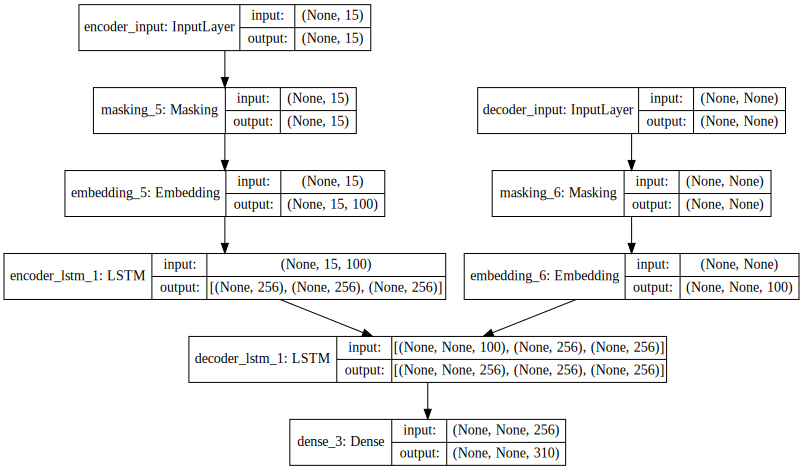

In [152]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Prepare train/test data.

In [153]:
encoder_input_data = X_train
decoder_input_data = y_train

In [154]:
# decoder_target_data will be ahead by one timestep
# and will not include the start token.
decoder_target_data = np.zeros(y_train_one_hot.shape)
decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]

In [155]:
decoder_target_data_test = np.zeros(y_test_one_hot.shape)
decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

In [156]:
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [157]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto', 
                                cooldown=0, min_lr=0)

In [158]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [159]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=([X_test, y_test], decoder_target_data_test),
          callbacks=[lr_callback, early_stopping_callback])

Train on 3499 samples, validate on 1501 samples
Epoch 1/500
3499/3499 [==============================] - 7s 2ms/step - loss: 3.3158 - val_loss: 2.5714
Epoch 2/500
3499/3499 [==============================] - 5s 2ms/step - loss: 2.3762 - val_loss: 2.1513
Epoch 3/500
3499/3499 [==============================] - 6s 2ms/step - loss: 1.8435 - val_loss: 1.5306
Epoch 4/500
3499/3499 [==============================] - 6s 2ms/step - loss: 1.3430 - val_loss: 1.1892
Epoch 5/500
3499/3499 [==============================] - 6s 2ms/step - loss: 1.0894 - val_loss: 1.0017
Epoch 6/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.9325 - val_loss: 0.8752
Epoch 7/500
3499/3499 [==============================] - 5s 2ms/step - loss: 0.8365 - val_loss: 0.8019
Epoch 8/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.7730 - val_loss: 0.7516
Epoch 9/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.7266 - val_loss: 0.7125
Epoch 10/500
3499/3499 [=

Epoch 78/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0063 - val_loss: 0.0811
Epoch 79/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0061 - val_loss: 0.0812
Epoch 80/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0062 - val_loss: 0.0814
Epoch 81/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0060 - val_loss: 0.0815

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 82/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0059 - val_loss: 0.0812
Epoch 83/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0058 - val_loss: 0.0813
Epoch 84/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0057 - val_loss: 0.0811
Epoch 85/500
3499/3499 [==============================] - 6s 2ms/step - loss: 0.0056 - val_loss: 0.0810

Epoch 00085: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 8

# Inference

We have trained a model, but how do we use it to actually translate sentences? We have to do more work ourselves here than with a non-recurrent neural net, so we'll write a function to help out. Here are the steps:

1. **Encode**:
    1. Run the entire input sentence through the encoder part of the model.
    1. Write down the "context vector" -- this is the state of the last LSTM encoder layer.<br><br>

2. **Decode in a loop**:
    1. Seed the decoder LSTM with the context vector.
    1. Run a *single step* of the decoder with the input "`<S>`" (the start symbol).
    1. Store the output. This is a word of the translation!
    1. Return to step 2B, but feed in the word from step 2C as the new input. Repeat until the decoder returns "`</S>`" (the end symbol).

In [160]:
# Define a version of our model for use in sampling (as opposed to training).
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 15)                0         
_________________________________________________________________
masking_5 (Masking)          (None, 15)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 15, 100)           20000     
_________________________________________________________________
encoder_lstm_1 (LSTM)        [(None, 256), (None, 256) 365568    
Total params: 385,568
Trainable params: 385,568
Non-trainable params: 0
_________________________________________________________________


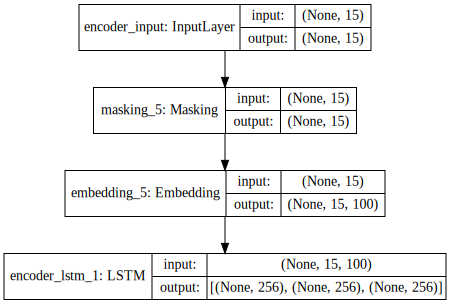

In [161]:
SVG(model_to_dot(encoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [162]:
# Build the decoder.
decoder_state_input_h = Input(shape=(NUM_LSTM_NODES,))
decoder_state_input_c = Input(shape=(NUM_LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_embedded, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
masking_6 (Masking)             (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 100)    31100       masking_6[0][0]                  
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_6 (I

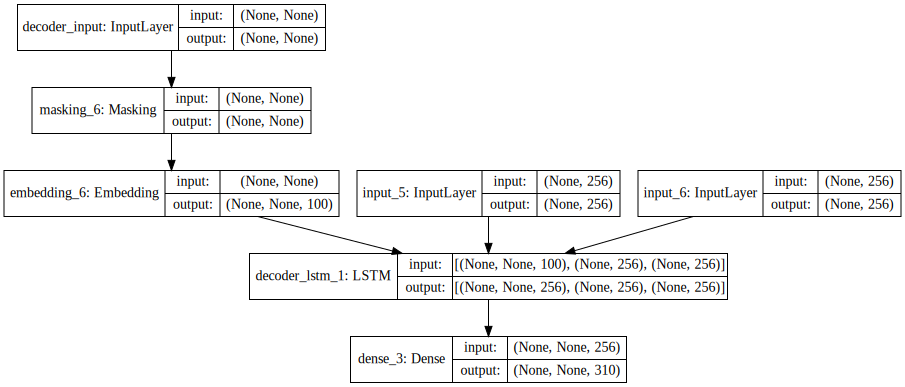

In [163]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [164]:
def translate_sequence(input_seq):
    # Encode the input as state vectors.
    # TODO: Use the encoder_model to get the h and c vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first word of target sequence with the start symbol '<S>'.
    target_seq[0, 0] = word_to_index2['<S>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    decoded_sentence = ''
    stop_condition = False
    step = 0
    # TODO: complete the loop.
    while not stop_condition:
        # Use the decoder to get the output token vector and the h and c vectors
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value) 

        # Find the largest value in the probability output vector, and use that index as your output word
        # at this time step.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word2[sampled_token_index]

        # Add the word to the output sentence string
        #if sampled_word != '<MASK>':
        decoded_sentence += ' ' + sampled_word
        
        # Stopping condition: either hit max length or find the stop token '</S>'.
        if (sampled_word == '</S>' or
           len(decoded_sentence) > 100):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    return decoded_sentence

# Test your network: feed in 10 sentences and show the results.

In [167]:
def trans(lst):
    
    tmp = [i for i in lst[::-1] if i != '<MASK>']
    return ('{} ' * len(tmp)).format(*tmp)

for i in range(10):
    # Print an input sentence
    # Translate it and print the output sentence
    
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[i: i + 1]
    #print(input_seq)
    decoded_sentence = translate_sequence(input_seq)[:translate_sequence(input_seq).find('<') -1]
    print('\n-')
    print('Input sentence:\n', trans(indices_to_sentence(input_seq[0], index_to_word1)))
    print('Decoded sentence:\n', decoded_sentence)


-
Input sentence:
 the united states is pleasant during december and it is rainy in winter 
Decoded sentence:
  états unis est agréable en décembre et il pleut en hiver

-
Input sentence:
 she likes apples limes and oranges 
Decoded sentence:
  aime les pommes les citrons verts et oranges

-
Input sentence:
 france is usually freezing during november and it is never rainy in may 
Decoded sentence:
  est le gel habituellement au mois de novembre et il est jamais pluvieux en mai

-
Input sentence:
 china is never quiet during spring but it is sometimes dry in september 
Decoded sentence:
  est jamais tranquille au printemps mais il est parfois sèche en septembre

-
Input sentence:
 china is warm during spring and it is sometimes cold in february 
Decoded sentence:
  est chaud au printemps et il est parfois froid en février

-
Input sentence:
 india is usually chilly during october but it is usually rainy in summer 
Decoded sentence:
  est généralement froid en octobre mais il est généra

In [166]:
'''
# copying the file for home usage
PATH = '../resource/asnlib/publicdata/'
LOCAL_PATH = './'

fr =  'small_vocab_fr.txt'
en = 'small_vocab_en.txt'

files = [[PATH + fr , LOCAL_PATH + fr], [PATH + en , LOCAL_PATH + en]]

for i in files:
    with open(i[0],"r") as f:
        with open(i[1], "w") as copy:
            for line in f:
                copy.write(line)
'''

'\n# copying the file for home usage\nPATH = \'../resource/asnlib/publicdata/\'\nLOCAL_PATH = \'./\'\n\nfr =  \'small_vocab_fr.txt\'\nen = \'small_vocab_en.txt\'\n\nfiles = [[PATH + fr , LOCAL_PATH + fr], [PATH + en , LOCAL_PATH + en]]\n\nfor i in files:\n    with open(i[0],"r") as f:\n        with open(i[1], "w") as copy:\n            for line in f:\n                copy.write(line)\n'

### Question: How well do you think the model did? Discuss any problems you ran into.

TODO

# Evaluate model accuracy

### Compute the accuracy of the model on the test set.
In a detailed study we would calculate the "BLEU" score for the translation task.
For this assignment, we'll keep things simple. Just calculate an all-or-nothing accuracy score on each translated sentence. If all the words appear in the output, in the correct order, without extra words, the score on that example is 1. Otherwise 0. Compute the accuracy over all examples in the test set. You may ignore punctuation (commas) and `<S>` and `</S>` symbols.

## Report the accuracy value you obtained.

TODO